# Project: Investigate a Dataset (No-Show Appointments)

- This dataset collects information from 100k medical appointments in Brazil and is focused on the question of whether or not patients show up for their appointment. A number of characteristics about the patient are included in each row.
    - ‘ScheduledDay’ tells us on what day the patient set up their appointment.
    - ‘Neighborhood’ indicates the location of the hospital.
    - ‘Scholarship’ indicates whether or not the patient is enrolled in Brasilian welfare program Bolsa Família.
    - Be careful about the encoding of the last column: it says ‘No’ if the patient showed up to their appointment, and ‘Yes’ if they did not show up.
    
    
- **The Questions We Want to Answer is**:
    - What factors are important for us to know in order to predict if a patient will show up for their scheduled appointment?

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#limitations">Limitations</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

<a id='wrangling'></a>
## Data Wrangling

- Data wrangling consists of three phases and the whole process are iterative in any phase:
    - Gathering data.
    - Assessing data.
    - Cleaning data.

### 1.Gathering Data
### Load noshowappointments.csv 

In [2]:
appoints_df = pd.read_csv('datasets/noshowappointments.csv')

### 2.Assessing Data
- get info , stats about data

### findings:
- Interseting Columns are ['Gender', 'ScheduledDay','AppointmentDay', 'Age', 'Neighbourhood', 'Scholarship', 'Hipertension', 'Diabetes', 'Alcoholism', 'Handcap', 'SMS_received', 'No-show']

- 'PatientId', 'AppointmentID' are identifiers columns for patient and appointment  and should be dropped.

- 'ScheduledDay','AppointmentDay' are strings and should be of type datetime.

- 'Age' column has 1 entry with value -1 (could be removed) and 3539 entry with value 0 (newborn).

- 'Scholarship', 'Hipertension','Diabetes', 'Alcoholism', 'SMS_received', 'No-show' are integers and should be of type boolean

In [3]:
appoints_df.sample(5)

,PatientId,AppointmentID,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
9363,5.186849e+14,5650561,M,2016-05-03T07:52:31Z,2016-05-03T00:00:00Z,59,SANTOS DUMONT,1,1,0,0,0,0,Yes
52871,3.626268e+13,5657306,F,2016-05-04T09:11:44Z,2016-05-04T00:00:00Z,24,SANTO ANDRÉ,0,0,0,0,0,0,No
63309,2.581487e+12,5657668,F,2016-05-04T09:43:45Z,2016-05-04T00:00:00Z,23,JARDIM DA PENHA,0,0,0,0,0,0,No
85003,5.924345e+11,5759691,F,2016-06-01T13:32:09Z,2016-06-08T00:00:00Z,7,PRAIA DO CANTO,0,0,0,0,0,1,Yes
49631,5.414268e+10,5565994,M,2016-04-11T09:44:56Z,2016-05-18T00:00:00Z,66,CENTRO,0,1,1,0,0,0,No


In [4]:
# edit columns names

appoints_df.columns = [col.strip().lower().replace('-','_') for col in appoints_df.columns.tolist()]
appoints_df.rename(columns = {'handcap':'handicap'},inplace=True)

In [5]:
appoints_df.columns

Index(['patientid', 'appointmentid', 'gender', 'scheduledday',
       'appointmentday', 'age', 'neighbourhood', 'scholarship', 'hipertension',
       'diabetes', 'alcoholism', 'handicap', 'sms_received', 'no_show'],
      dtype='object')

In [6]:
appoints_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 110527 entries, 0 to 110526
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   patientid       110527 non-null  float64
 1   appointmentid   110527 non-null  int64  
 2   gender          110527 non-null  object 
 3   scheduledday    110527 non-null  object 
 4   appointmentday  110527 non-null  object 
 5   age             110527 non-null  int64  
 6   neighbourhood   110527 non-null  object 
 7   scholarship     110527 non-null  int64  
 8   hipertension    110527 non-null  int64  
 9   diabetes        110527 non-null  int64  
 10  alcoholism      110527 non-null  int64  
 11  handicap        110527 non-null  int64  
 12  sms_received    110527 non-null  int64  
 13  no_show         110527 non-null  object 
dtypes: float64(1), int64(8), object(5)
memory usage: 11.8+ MB


In [7]:
appoints_df.describe().T

,count,mean,std,min,25%,50%,75%,max
patientid,110527.0,1.474963e+14,2.560949e+14,3.921784e+04,4.172614e+12,3.173184e+13,9.439172e+13,9.999816e+14
appointmentid,110527.0,5.675305e+06,7.129575e+04,5.030230e+06,5.640286e+06,5.680573e+06,5.725524e+06,5.790484e+06
age,110527.0,3.708887e+01,2.311020e+01,-1.000000e+00,1.800000e+01,3.700000e+01,5.500000e+01,1.150000e+02
scholarship,110527.0,9.826558e-02,2.976748e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
hipertension,110527.0,1.972459e-01,3.979213e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
diabetes,110527.0,7.186479e-02,2.582651e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
alcoholism,110527.0,3.039981e-02,1.716856e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00
handicap,110527.0,2.224796e-02,1.615427e-01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,4.000000e+00
sms_received,110527.0,3.210256e-01,4.668727e-01,0.000000e+00,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00


In [8]:
#check duplicates in data

appoints_df.duplicated().sum()

0

In [9]:
#check missing values in data

appoints_df.isnull().sum().sum()

0

In [10]:
#findings for columns : 'gender'

print(appoints_df.gender.value_counts(dropna=False))
print(appoints_df.gender.dtype)

F    71840
M    38687
Name: gender, dtype: int64
object


In [11]:
#findings for columns : 'scheduledday','appointmentday'

# print(appoints_df.scheduledday.value_counts().sort_index())
print('Min Scheduled Day: {}'.format(appoints_df.scheduledday.min()))
print('Max Scheduled Day: {}'.format(appoints_df.scheduledday.max()))
print('No. of Unique Scheduled Days: {}'.format(appoints_df.scheduledday.nunique()))
print('Type of Scheduled Day Column : {}'.format(appoints_df.scheduledday.dtype))

# print(appoints_df.appointmentday.value_counts().sort_index())
print('\nMin Appointment Day: {}'.format(appoints_df.appointmentday.min()))
print('Max Appointment Day: {}'.format(appoints_df.appointmentday.max()))
print('No. of Unique Appointment Days: {}'.format(appoints_df.appointmentday.nunique()))
print('Type of Appointment Day Column : {}'.format(appoints_df.appointmentday.dtype))

Min Scheduled Day: 2015-11-10T07:13:56Z
Max Scheduled Day: 2016-06-08T20:07:23Z
No. of Unique Scheduled Days: 103549
Type of Scheduled Day Column : object

Min Appointment Day: 2016-04-29T00:00:00Z
Max Appointment Day: 2016-06-08T00:00:00Z
No. of Unique Appointment Days: 27
Type of Appointment Day Column : object


In [12]:
#findings for columns : 'Age'

print(appoints_df.age.value_counts().sort_index())
print(appoints_df.age.dtype)

-1         1
 0      3539
 1      2273
 2      1618
 3      1513
        ... 
 98        6
 99        1
 100       4
 102       2
 115       5
Name: age, Length: 104, dtype: int64
int64


In [13]:
#findings for columns : 'neighbourhood'

print(appoints_df.neighbourhood.value_counts())
print(appoints_df.neighbourhood.dtype)

JARDIM CAMBURI                 7717
MARIA ORTIZ                    5805
RESISTÊNCIA                    4431
JARDIM DA PENHA                3877
ITARARÉ                        3514
                               ... 
ILHA DO BOI                      35
ILHA DO FRADE                    10
AEROPORTO                         8
ILHAS OCEÂNICAS DE TRINDADE       2
PARQUE INDUSTRIAL                 1
Name: neighbourhood, Length: 81, dtype: int64
object


In [14]:
#findings for columns : 'handicap'

print(appoints_df.handicap.value_counts())
print(appoints_df.handicap.dtype)

0    108286
1      2042
2       183
3        13
4         3
Name: handicap, dtype: int64
int64


In [15]:
#findings for columns : 'scholarship', 'hipertension','diabetes', 'alcoholism',  'sms_received', 'no_show'

print(appoints_df.scholarship.value_counts())
print(appoints_df.scholarship.dtype, end='\n\n')

print(appoints_df.hipertension.value_counts())
print(appoints_df.hipertension.dtype, end='\n\n')

print(appoints_df.diabetes.value_counts())
print(appoints_df.diabetes.dtype, end='\n\n')

print(appoints_df.alcoholism.value_counts())
print(appoints_df.alcoholism.dtype, end='\n\n')

print(appoints_df.sms_received.value_counts())
print(appoints_df.sms_received.dtype, end='\n\n')

print(appoints_df.no_show.value_counts())
print(appoints_df.no_show.dtype, end='\n\n')

0    99666
1    10861
Name: scholarship, dtype: int64
int64

0    88726
1    21801
Name: hipertension, dtype: int64
int64

0    102584
1      7943
Name: diabetes, dtype: int64
int64

0    107167
1      3360
Name: alcoholism, dtype: int64
int64

0    75045
1    35482
Name: sms_received, dtype: int64
int64

No     88208
Yes    22319
Name: no_show, dtype: int64
object



### 3.Data Cleaning 

#### work on copy of the original data frame

In [16]:
appoints_clean = appoints_df.copy()

### Drop unneeded columns

### Define
- 'patientid', 'appointmentid' are identifiers columns for patient and appointment  and should be dropped.

### Code

In [17]:
appoints_clean.drop(['patientid', 'appointmentid'],axis=1,inplace=True);

### Test

In [18]:
appoints_clean.columns

Index(['gender', 'scheduledday', 'appointmentday', 'age', 'neighbourhood',
       'scholarship', 'hipertension', 'diabetes', 'alcoholism', 'handicap',
       'sms_received', 'no_show'],
      dtype='object')

### Erroneous datatypes

### Define
- 'scheduledday', 'appointmentday' are strings and should be of type datetime.
- 'scholarship', 'hipertension', 'diabetes', 'alcoholism','sms_received', 'no_show' are integers and should be of type boolean

### Code

In [19]:
# converting scheduledday,appointmentday to datetime column
appoints_clean['scheduledday'] = pd.to_datetime(appoints_clean['scheduledday'])
appoints_clean['appointmentday'] = pd.to_datetime(appoints_clean['appointmentday'])

# mapping values in no_show columns to 0 (attended appointment), 1 (missed appointment) to be converted to bool
appoints_clean['no_show'] = appoints_clean['no_show'].map({
    'No':0,
    'Yes':1
}).astype(bool)

# concverting scholarship, hipertension, diabetes, alcoholism, sms_received to bool
bool_columns = ['scholarship', 'hipertension', 'diabetes', 'alcoholism','sms_received']
appoints_clean[bool_columns] = appoints_clean[bool_columns].astype(bool)

### Test

In [20]:
appoints_clean.dtypes

gender                         object
scheduledday      datetime64[ns, UTC]
appointmentday    datetime64[ns, UTC]
age                             int64
neighbourhood                  object
scholarship                      bool
hipertension                     bool
diabetes                         bool
alcoholism                       bool
handicap                        int64
sms_received                     bool
no_show                          bool
dtype: object

### Define
- 'age' column has 1 entry with value -1 

### Code


In [21]:
row_index = appoints_clean[appoints_clean.age== -1].index
appoints_clean.drop(index=row_index,inplace=True)

### Test

In [22]:
appoints_clean[appoints_clean.age == -1]

,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handicap,sms_received,no_show


### Save Cleaned Data

In [23]:
appoints_clean.to_csv('datasets/noshowappointments_cleaned.csv', index=False)

<a id='eda'></a>
## Exploratory Data Analysis


In [24]:
#make masks for attend , missed conditions

attended = appoints_clean.no_show==False
missed = appoints_clean.no_show==True

### Research Question

###  Checking the percentage of appointments attended vs missed
- the percentage of attending the appointment is way higher than missing it

In [25]:
appoints_clean.no_show.value_counts(normalize=True)*100

False    79.806561
True     20.193439
Name: no_show, dtype: float64

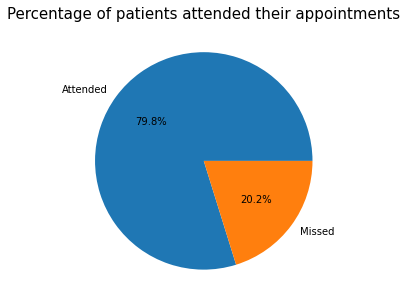

In [26]:
appoints_clean.no_show.value_counts(normalize=True).plot.pie(figsize=(5,5) ,labels=['Attended','Missed'], autopct='%.1f%%' );
plt.title("Percentage of patients attended their appointments",fontsize=15)
plt.ylabel('');

### Research Question

### Checking the percentage of Female vs Male
- it will help to better understand the if gender affects the no_show
- females in dataset are bout 65% and males are about 35%

In [27]:
appoints_clean.gender.value_counts(normalize=True)*100

F    64.997376
M    35.002624
Name: gender, dtype: float64

### Research Question

### Does patient gender affect the percentage of attending the appointments ??


In [28]:
print(appoints_clean.loc[attended , 'gender'].value_counts(normalize=True)*100)
print(appoints_clean.loc[missed , 'gender'].value_counts(normalize=True)*100)

F    64.898477
M    35.101523
Name: gender, dtype: float64
F    65.388234
M    34.611766
Name: gender, dtype: float64


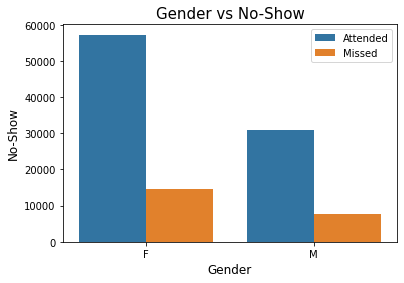

In [29]:
sns.countplot(x = 'gender', hue = 'no_show', data = appoints_clean);
plt.title("Gender vs No-Show",fontsize=15);
plt.xlabel('Gender',fontsize=12);
plt.ylabel('No-Show',fontsize=12);
plt.legend(['Attended','Missed']);

### Conclusion :

- **It seems that gender has not effect on appointment attendance percentage**
- missing percentage and attending percentage for females and males are almost the same of females and males percentage in the dataset

### Research Question

### Does patient age affect the percentage of attending the appointments ??


In [30]:
print(appoints_clean.age.value_counts().sort_values(ascending=False))
print(appoints_clean.age.describe())

0      3539
1      2273
52     1746
49     1652
53     1651
       ... 
98        6
115       5
100       4
102       2
99        1
Name: age, Length: 103, dtype: int64
count    110526.000000
mean         37.089219
std          23.110026
min           0.000000
25%          18.000000
50%          37.000000
75%          55.000000
max         115.000000
Name: age, dtype: float64


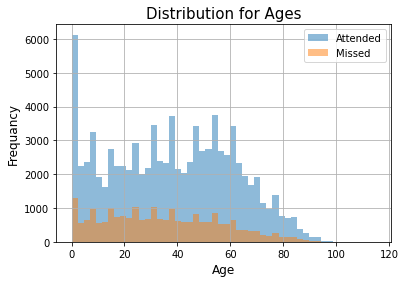

In [31]:
appoints_clean.loc[attended ,'age'].hist(alpha=0.5,bins=50,label='Attended');
appoints_clean.loc[missed ,'age'].hist(alpha=0.5,bins=50,label='Missed');
plt.title("Distribution for Ages", fontsize = 15)
plt.xlabel('Age', fontsize = 12)
plt.ylabel('Frequancy', fontsize = 12)
plt.legend();

In [32]:
bins=[0, 10, 20,30,40,50,60,70,80,90,100,110,120]
labels=['0-10','10-20','20-30','30-40','40-50','50-60','60-70','70-80','80-90','90-100','100-110','110-120']
appoints_clean['age_category'] = pd.cut(appoints_clean['age'],bins=bins , include_lowest=True,labels = labels )

In [33]:
appoints_clean.groupby('age_category')['no_show'].value_counts(normalize=True)*100

age_category  no_show
0-10          False       79.796256
              True        20.203744
10-20         False       74.746164
              True        25.253836
20-30         False       75.375463
              True        24.624537
30-40         False       78.527770
              True        21.472230
40-50         False       80.097087
              True        19.902913
50-60         False       82.625631
              True        17.374369
60-70         False       85.271249
              True        14.728751
70-80         False       84.460759
              True        15.539241
80-90         False       84.001572
              True        15.998428
90-100        False       80.398671
              True        19.601329
100-110       False      100.000000
110-120       True        60.000000
              False       40.000000
Name: no_show, dtype: float64

Text(0, 0.5, 'Frequancy')

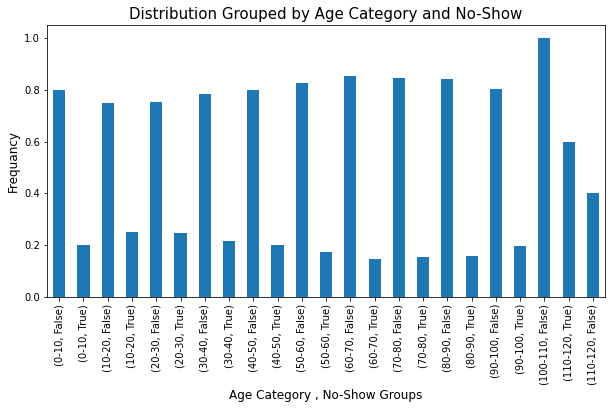

In [34]:
#appoints_clean.groupby(['age_category','no_show'])['no_show'].count().plot(kind='bar',figsize=(10,5))
appoints_clean.groupby('age_category')['no_show'].value_counts(normalize=True).plot.bar(figsize=(10,5));
plt.title("Distribution Grouped by Age Category and No-Show", fontsize = 15)
plt.xlabel('Age Category , No-Show Groups', fontsize = 12)
plt.ylabel('Frequancy', fontsize = 12)

In [35]:
appoints_clean.loc[(appoints_clean['age']>=100) & (appoints_clean['age']<110),['age','no_show']]

,age,no_show
58014,102,False
79270,100,False
79272,100,False
90372,102,False
92084,100,False
108506,100,False


### Conclusion :
- **It seems that age has no correlation with attending the appointments**
- distribution for attending and missing appointments are similar when grouping by age-category and no_show
- age category (100-110) has rate 100% on showing for their appointments but their were only 6 patients in this category

### Research Question

### Does handicap affect the percentage of attending the appointments ??

In [36]:
def create_bar_plot(df , x_col, y_col):
    bar_plot = df.groupby(x_col)[y_col].mean()    
    plt.title('{} vs {}'.format(x_col.title(), y_col.title() ) ,fontsize=15)
    plt.xlabel(x_col.title(), fontsize=12)
    plt.ylabel(y_col.title(), fontsize=12)
    bar_plot.plot(kind='bar')

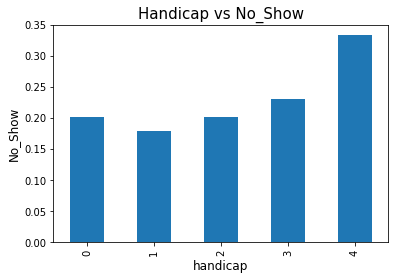

In [37]:
create_bar_plot(df= appoints_clean , x_col= 'handicap' , y_col= 'no_show')

### Conclusion : 
- **It seems that Handcap has positive correlation with No-show 'missing' the appointments**

### Research Question

### Does registering in the Scholarship program affect the percentage of attending the appointments ??
### Do Hipertension,Diabetes or Alcoholism columns affect the percentage of attending the appointments ??

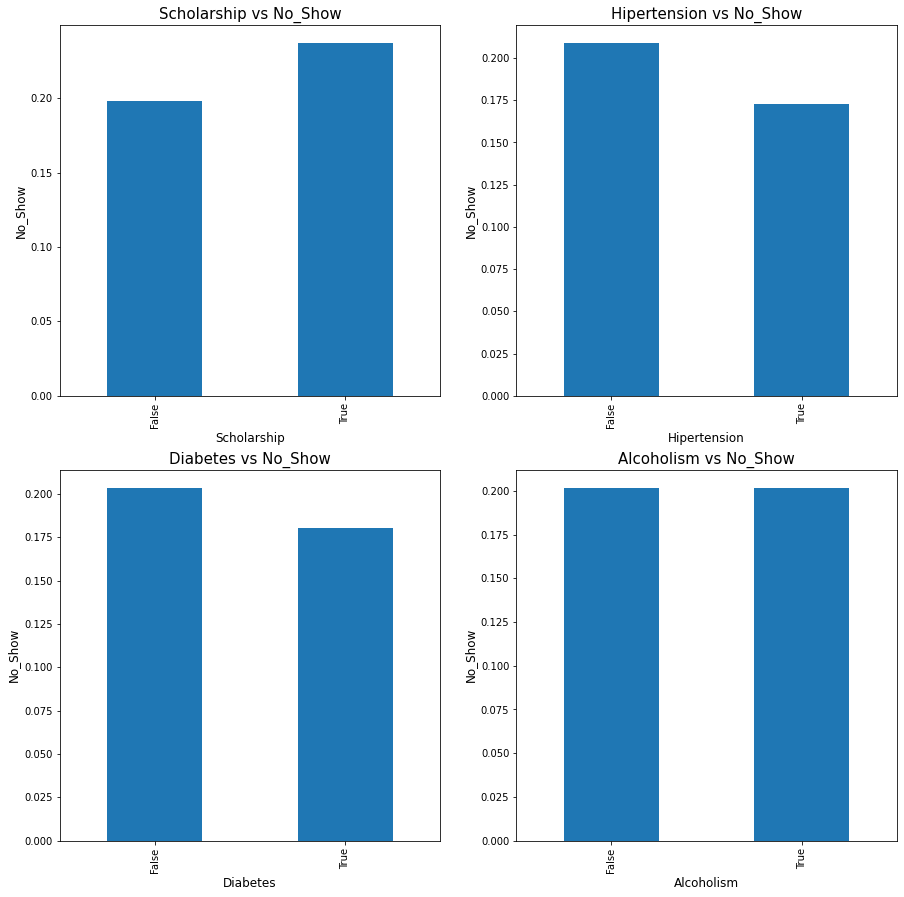

In [38]:
fig = plt.figure(figsize=(15,15))

columns = ['scholarship','hipertension','diabetes','alcoholism']
for i in range(4):
    ax = fig.add_subplot(2,2,i+1)
    ax.plot = create_bar_plot(df= appoints_clean , x_col= columns[i] , y_col= 'no_show')
    ax.set_xlabel(columns[i].title(), fontsize=12)
    ax.set_ylabel('no_show'.title(), fontsize=12)


### Conclusion :

- **It seems that registering in the Scholarship program has no such great effect in making patients attend the appointments.**
- **It seems also that Hipertension,Diabetes,Alcoholism don't affect in No show.**

### Research Question

### Does Sending SMS increases the percentage of attending the appointments ??

In [39]:
appoints_clean.sms_received.value_counts(normalize=True)*100

False    67.897146
True     32.102854
Name: sms_received, dtype: float64

In [40]:
print(appoints_clean.loc[attended , 'sms_received'].value_counts(normalize=True)*100)
print(appoints_clean.loc[missed , 'sms_received'].value_counts(normalize=True)*100)

False    70.866258
True     29.133742
Name: sms_received, dtype: float64
False    56.162911
True     43.837089
Name: sms_received, dtype: float64


Text(0.5, 0, 'SMS_Received')

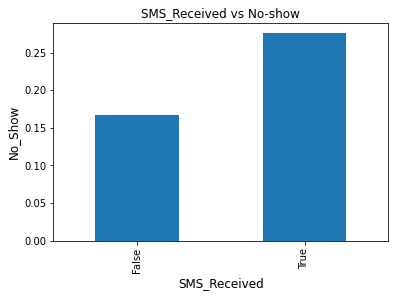

In [41]:
create_bar_plot(df= appoints_clean , x_col= 'sms_received' , y_col= 'no_show')

plt.title('SMS_Received vs No-show')
plt.xlabel('SMS_Received',fontsize=12)


### Conclusion :
- **It seems that SMS does not have great effect in making patients attend their appointments.**

### Research Question

### Does waiting days between schedule and appointment day affect the percentage of attending the appointments ??
- AppointmentDay column doesn't have hour info so we could consider -1 as the same day
- for entries with -2,-7 , I will drop them

In [42]:
appoints_clean['waiting_days'] =(appoints_clean['appointmentday'] - appoints_clean['scheduledday']).dt.days

In [43]:
print(appoints_clean['waiting_days'].value_counts().sort_index())
print(appoints_clean['waiting_days'].describe())

-7          1
-2          4
-1      38562
 0       5213
 1       6725
        ...  
 154       10
 161       11
 168        8
 175       16
 178       10
Name: waiting_days, Length: 131, dtype: int64
count    110526.000000
mean          9.183794
std          15.255034
min          -7.000000
25%          -1.000000
50%           3.000000
75%          14.000000
max         178.000000
Name: waiting_days, dtype: float64


In [44]:
appoints_clean[appoints_clean['waiting_days'] < -1]

,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handicap,sms_received,no_show,age_category,waiting_days
27033,M,2016-05-10 10:51:53+00:00,2016-05-09 00:00:00+00:00,38,RESISTÊNCIA,False,False,False,False,1,False,True,30-40,-2
55226,F,2016-05-18 14:50:41+00:00,2016-05-17 00:00:00+00:00,19,SANTO ANTÔNIO,False,False,False,False,1,False,True,10-20,-2
64175,F,2016-05-05 13:43:58+00:00,2016-05-04 00:00:00+00:00,22,CONSOLAÇÃO,False,False,False,False,0,False,True,20-30,-2
71533,F,2016-05-11 13:49:20+00:00,2016-05-05 00:00:00+00:00,81,SANTO ANTÔNIO,False,False,False,False,0,False,True,80-90,-7
72362,M,2016-05-04 06:50:57+00:00,2016-05-03 00:00:00+00:00,7,TABUAZEIRO,False,False,False,False,0,False,True,0-10,-2


In [45]:
appoints_clean[appoints_clean['waiting_days'] <= 0 ]

,gender,scheduledday,appointmentday,age,neighbourhood,scholarship,hipertension,diabetes,alcoholism,handicap,sms_received,no_show,age_category,waiting_days
0,F,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,False,True,False,False,0,False,False,60-70,-1
1,M,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,False,False,False,0,False,False,50-60,-1
2,F,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,False,False,False,False,0,False,False,60-70,-1
3,F,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,False,False,False,False,0,False,False,0-10,-1
4,F,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,False,True,True,False,0,False,False,50-60,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110512,F,2016-06-08 08:20:01+00:00,2016-06-08 00:00:00+00:00,41,MARIA ORTIZ,False,False,False,False,0,False,False,40-50,-1
110513,M,2016-06-08 07:52:55+00:00,2016-06-08 00:00:00+00:00,2,ANTÔNIO HONÓRIO,False,False,False,False,0,False,False,0-10,-1
110514,F,2016-06-08 08:35:31+00:00,2016-06-08 00:00:00+00:00,58,MARIA ORTIZ,False,False,False,False,0,False,False,50-60,-1
110516,F,2016-06-07 07:45:16+00:00,2016-06-08 00:00:00+00:00,37,MARIA ORTIZ,False,False,False,False,0,False,True,30-40,0


In [46]:
print('Before : {}'.format(appoints_clean.shape))
appoints_clean['waiting_days']  = appoints_clean['waiting_days'].replace(-2,np.nan).replace(-7,np.nan).replace(-1,0)
appoints_clean.dropna(inplace=True)
print('After : {}'.format(appoints_clean.shape))

Before : (110526, 14)
After : (110521, 14)


In [47]:
appoints_clean['waiting_days'].value_counts()

0.0      43775
1.0       6725
3.0       5290
6.0       4906
5.0       4037
         ...  
81.0         1
116.0        1
131.0        1
126.0        1
124.0        1
Name: waiting_days, Length: 128, dtype: int64

In [48]:
appoints_clean.groupby('waiting_days')['no_show'].value_counts(normalize=True).sort_index()[:10]*100

waiting_days  no_show
0.0           False      93.363792
              True        6.636208
1.0           False      76.178439
              True       23.821561
2.0           False      76.470588
              True       23.529412
3.0           False      76.729679
              True       23.270321
4.0           False      73.390296
              True       26.609704
Name: no_show, dtype: float64

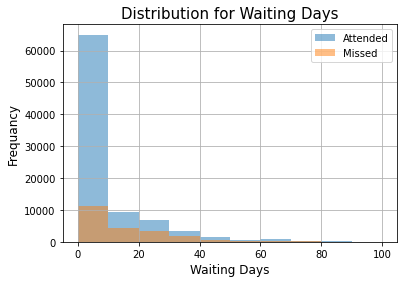

In [49]:
appoints_clean.loc[attended ,'waiting_days'].hist(alpha=0.5,range=[0,100],label='Attended');
appoints_clean.loc[missed ,'waiting_days'].hist(alpha=0.5,range=[0,100],label='Missed');
plt.title("Distribution for Waiting Days", fontsize = 15)
plt.xlabel('Waiting Days', fontsize = 12)
plt.ylabel('Frequancy', fontsize = 12)
plt.legend();

### Conclusion :
- **It seems that the waiting days have segnificant impact in attending the appointment.**
- **increasing the waiting days between scheduled day and appointment day leads to a higher percentage for No-Show**

<a id='limitations'></a>
## Limitations

- The dataset missing many helpful features like :
    - the dataset not including patient address which could make helpful insights combined with the location of the hospital.
    - the dataset not including which medical treatment  the patient had, it could make great insights for which medical treatments the patients tends to No-Show.
    - there are missing in hour information at 'appointmentday' column which could be analyzed to get insights about most hour the patients tends to No-Show.
    - the dataset not including for how long the patients had diseases ('hipertension','diabetes','alcoholism','handocap') , the patient behaviour could be changed after finding out about theses diseases. 
    - the sms_received could be more insightful if it states the datetime , it could be analyzed to get the best no. of days before appointment, the sms should be sent to remind the patient about appointmnet .

<a id='conclusions'></a>
## Conclusions

- Gender has not effect on showing for schedualed appointment.
- Age also has no clear correlation with attending the appointments.
- Handcap has positive correlation with No-show 'missing' the appointments.
- It seems that registering in the Scholarship program has no such great effect in making patients attend the appointments.
- Sending SMS, unlike expected, don't significantly increase the percentage of attending the appointments .
- It seems also that Hipertension,Diabetes,Alcoholism don't affect in No show percentage.
- increasing the waiting days between scheduled day and appointment day leads to a higher percentage for No-show.